# Implementing a deep neural network from scratch

Gilles Deknache February 2024

This project has been assigned by Prof. Michal Madden as an assignment for the Deep Learning module at the University of Galway. It consists of 5 parts:
- Part 1: Implementing logistic regression, which is the basis of a neural network.
- Part 2: Testing on blob and circle dataset
- Part 3: Implementing a shallow neural network, which is a neural network with only one layer.
- Part 4: Testing a Fashion-MNIST dataset, selecting only two classes
- Part 5: Implementing a deep neural network, which supports any given structure and provides further improvement.
    - I chose to implement a multi-class classifier, adding the softmax function for the last layer.
- Part 6: Testing on the Fashion-MNIST dataset for the 9 classes (I added this part)

Sources used in the project : 
- Prof Michael Madden's lecture slides
- Numpy documentation for dot product: https://numpy.org/doc/stable/reference/generated/numpy.dot.html  
and matmul : https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
- previous knowledge of neural networks and Python, so I did not use any external sources

## Part 1: Implementing logistic regression
Logistic regression is actually a binary classification algorithm, not a regression algorithm. It tries to find an optimal linear line separating two classes. It is basically a linear regressor with an activation function to compute the binary prediction.

Logistic regression is the core component of a neural network. It can also be referred to as a perceptron or a single-node neural network.   

**NOTE**  

The main difference between logistic regression and a perceptron is the activation function:
- A perceptron uses a step function (hard threshold).
- Logistic regression uses a sigmoid function $\frac{^{1}}{1+e^{-x}}$ (soft threshold).

However, the structure of the algorithm is the same: 

- Initialisation of the parameters $w$ and $b$ (usually normal distribution)
- While the convergence criteria are not met
    - Forward propagation $\hat{y} = f(w.x + b)$ where f is the activation function and . is a simple dot product.
    - Calculate the cost function $J = y*log(y) + (1-y)*log(y)$.
    - Compute the gradient of $J$ with respect to $w$ : $Dw = (y-\hat{y})*x$.
    - Gradient descent $w -= lr*Dw$ and $b -= lr*db$.
    - Check for convergence


Implementation detail :
- I chose to store the parameters in a numpy array, which is handy for matrix multiplication and vectorisation. 
- However, for back propagation I did not use vectorisation, so for a better understanding
- I have tried to stay consistent with the following notation for my variable: 
    - `x` represents the input vector (single sample) and y its label.
    - `J` is the cost function computed at each iteration of the gradient descent.
    - `w` is a weight vector of the same length as `x`, `w[i]` corresponds to the weight associated with the input `x[i]`.
    - `b` is the bias
    - `DW[i]` and DB are the slope of J with respect to `w[i]` and `b` respectively.

In [5]:
import numpy as np # array manipulation
import random as rd # randomness
import pandas as pd # dataframe manipulation
import matplotlib.pyplot as plt # ploting
from sklearn.metrics import accuracy_score,confusion_matrix # score metrics
import seaborn as sns # more visualisation

In [6]:
def sigmoid(x):
    """sigmoid function return 1 / (1 + e^-x)"""
    return 1/(1+np.exp(-x))

In [7]:
def logistic_regression(X,Y,lr = 0.001, max_iterations = 1000000,eps = 1e-4,mu = 0,sigma = 0.1,display = False):
    """
    X is training data, must ne numeric
    Y is the label, must be binary because we are doing binary classification
    lr is the learning rate of gradient descent
    max_iterations is the maximum number of iteration if convergence is not reached
    esp is thex treshold to check for convergence
    """

    # initialise parameters

    stopping = False
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    w = np.random.normal(mu,sigma,size=X.shape[1])
    b = np.random.normal(mu,sigma)
    N = len(X[:,1]) #number of sample in Training data

    # Convergence is not reached or max_iterations
    while not stopping:
        #Set {x, y} = single example from training set selected at random
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        # Forward propagation stage
        y_hat = sigmoid(np.dot(x,w) + b) 

        #Calculate J_current from y, y_hat
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat+1e-8))

        DW = []
        DB = []
        # Back propagation
        for j in range(len(w)):
            DW.append((y_hat-y)*x[j])
            DB.append(y_hat-y)
        # Gradient descent 
        for j in range(len(w)):
            w[j] -= lr * DW[j]
            b -= lr * DB[j]

        # Check stopping criteria
        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1 # epoch is updated when forward pass and backprop has been done on (approximately) all data
            J_running = J_running / N # Average of the cost function
            J_list.append(J_running) # update list at each epoch
            if abs(J_running - J_running_prev) < eps : stopping = True
            J_running_prev = J_running
            J_running = 0
            if display == True :
                print(f'epoch {epoch} J = {J_running_prev}')

    # Print wether the convergence is reached or not
    if iteration == max_iterations+1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    
    
    return (J_list,w,b)

#### Testing

In [8]:
X = np.array([[2,3,4.89,0,1],
              [1,2,4,5,10]])
Y = np.array([0,1])
J_list,w,b = logistic_regression(X,Y);
print(J_list[0],J_list[-1])

Training complete, convergence is reached after 566 epochs
0.5777966046319076 0.05630529097564446


## Part 2 : Easy tasks

### Blob dataset

In [9]:
blob = pd.read_csv('blobs400.csv')
X_blob = blob[['X1','X2','X3']]
Y_blob = blob['Class']
X_blob = X_blob.to_numpy()
Y_blob = Y_blob.to_numpy()

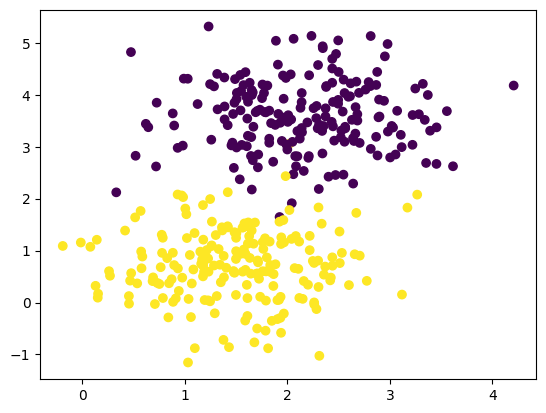

In [10]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap='viridis');

In [11]:
def predict_logistic(X,w,b):
    """ forward pass for logistic regression and threshold for prediction """
    y_pred = sigmoid(np.dot(X,w) + b) 
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary

#### Train test split

Train 50 %  
Validation 25 %  
Test 25 %  

In [12]:
from sklearn.model_selection import train_test_split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_blob, Y_blob, test_size=0.5, random_state=42)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=42)

#### Training

In [13]:
J_list,w,b = logistic_regression(X_train_b,y_train_b,lr = 0.001,eps = 1e-6,max_iterations=1000000)

max iteration reached, convergence is not reached you may need to adjust parameters


#### Learning curve

Text(0.5, 1.0, 'Learning curve')

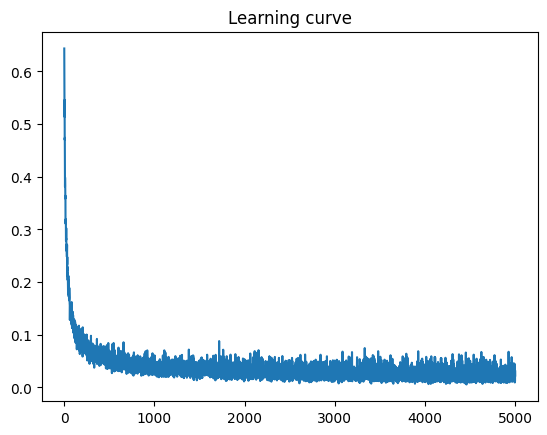

In [14]:
import matplotlib.pyplot as plt
plt.plot(J_list)
plt.title("Learning curve")

Note on the training curve:
- Effect of parameter initialisation
    - for `mu = 0` and `nu = 1` I have faster convergence, but each time I rerun the algorithm I have a different shape of a learning curve
    - for `mu = 0` and `nu = 0.1` I have more epochs but always the same shape of a learning curve, so there is less variability
- Effect of learning rate : 
    - for `lr = 0.1` we observe instability and convergence is not reached after 1 million iterations
    - For `lr = 0.001` convergence is reached but there is still some instability. 

I keep `nu = 0.1` for the rest of the assignment to have good reproducibility and less variability between results (we could also set a random seed).  
The instability can be explained by the fact that stochastic gradient descent is stochastic, so the gradient may not be exact, as the parameters may "zigzag" their way through the optimal solution.

#### Validation

In [15]:
# Validation
from sklearn.metrics import accuracy_score
y_pred = predict_logistic(X_val_b,w,b)
acc = accuracy_score(y_pred,y_val_b)
print(f'Validation accuracy score : {acc: .3f}')

Validation accuracy score :  0.960


Experiments : 
- `lr = 0.001 and eps = 1e-6 `--> 0.960
- `lr = 0.001 and eps = 1e-7` --> O.960 but convergence is not reached
- `lr = 0.0005, eps = 1e-6` --> 0.960 but convergence is not reached
- `lr = 0.0005, eps = 1e-6 max_iterations = 10 millions` --> 0.950 and convergence is reached --> overfitting !

Based on these experiments on the validation set I will set the parameter to lr = 0.001, eps = 1e-6 and max_iteration = 1 million for the test set

#### Test

In [16]:
# Train on train + validation set 
X_train_b_tot = np.concatenate((X_train_b, X_val_b), axis=0)
y_train_b_tot = np.concatenate((y_train_b, y_val_b), axis=0)
J_list,w,b = logistic_regression(X_train_b_tot,y_train_b_tot,lr = 0.001,eps = 1e-6,max_iterations=1000000)

max iteration reached, convergence is not reached you may need to adjust parameters


We see that convergence is not reached but I won't increase the max_iterations to avoid overfitting

In [17]:
y_pred = predict_logistic(X_test_b,w,b)
acc = accuracy_score(y_pred,y_test_b)
print(f'Test accuracy score : {acc: .3f}')

Test accuracy score :  0.990


The accuracy is not equal to 1 because data has been generated with noise, therefore it is not perfeclty linearly seperable. However the result is very close to 1 so algorithm is working good.

#### Visualisation of the result

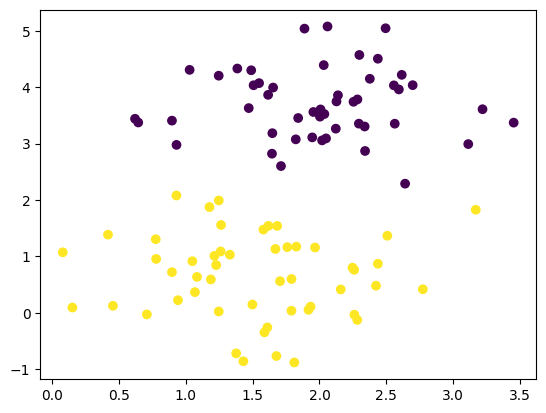

In [18]:
plt.scatter(X_test_b[:, 0], X_test_b[:, 1], c=y_pred, cmap='viridis');

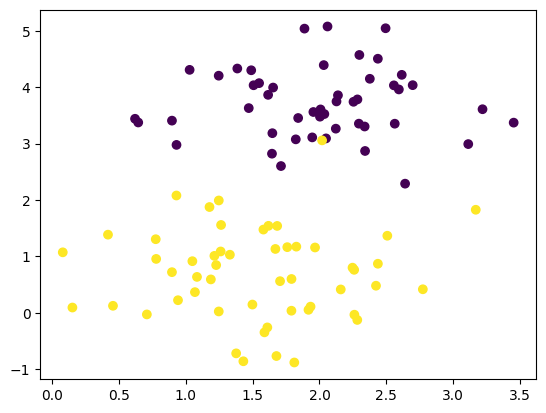

In [19]:
plt.scatter(X_test_b[:, 0], X_test_b[:, 1], c=y_test_b, cmap='viridis');

We can see here one yellow point that is not linearly separate from the other class ( at least on this 2 dimensions) so the algorithm is missclassifying it

### Circle dataset

I will use the same methodology for this dataset

In [20]:
circle = pd.read_csv('circles500.csv')
X_circle = circle[['X0','X1']]
Y_circle = circle[['Class']]
X_circle = X_circle.to_numpy()
Y_circle = Y_circle.to_numpy()
Y_circle = Y_circle.reshape(500)

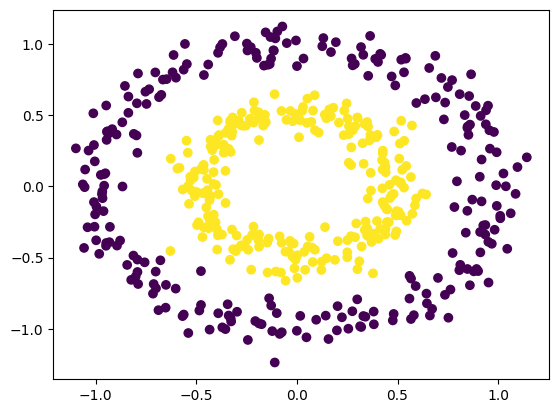

In [21]:
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle, cmap='viridis');

In [22]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_circle, Y_circle, test_size=0.7, random_state=42)
X_test_c, X_val_c, y_test_c, y_val_c = train_test_split(X_test_c, y_test_c, test_size=0.5, random_state=42)

In [23]:
J_list,w,b = logistic_regression(X_train_c,y_train_c,lr = 0.001,eps =1e-4,max_iterations=1000000,sigma = 2)

Training complete, convergence is reached after 259 epochs


Text(0.5, 1.0, 'Learning curve')

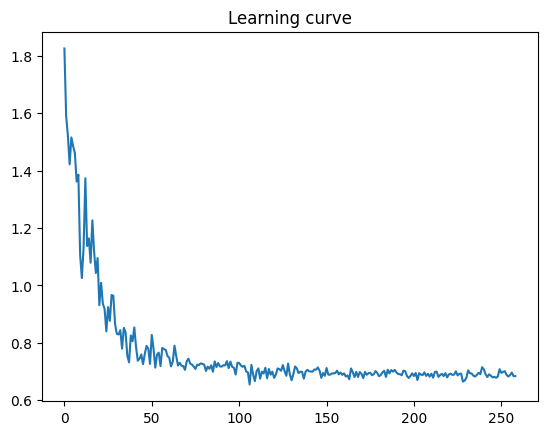

In [24]:
plt.plot(J_list)
plt.title("Learning curve")

#### Notes 
- I had to set `sigma = 2` to observe the learning curve  by adding artificially some error at the inittialisation
- Every parameter setting leads to poor result because the data is not linearly seperable
- Therefore, I will not perform parameter tuning

In [25]:
y_pred = predict_logistic(X_val_c,w,b)
acc = accuracy_score(y_pred,y_val_c)
print(f'Validation score : {acc: .3f}')

Validation score :  0.383


In [26]:
y_pred = predict_logistic(X_test_c,w,b)
acc = accuracy_score(y_pred,y_test_c)
print(f'Test Accuracy score : {acc: .3f}')

Test Accuracy score :  0.371


#### Visualisation

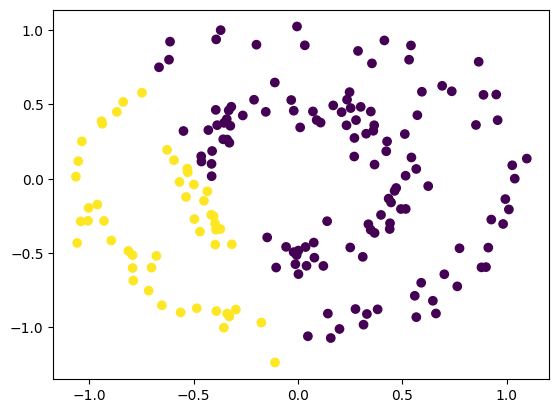

In [27]:
plt.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_pred, cmap='viridis');

We can see that the algorithm try to separate the data with a straight line but the circle data is not linearly separable

## Part 3

A shallow neural network is a neural network with only two layers. The implementation will only involve binary classification.  
It works similarly to logistic regression but with a more complex structure that will be able to learn non-linear patterns.

Initialising the parameters:   
There are now 2 layers, so we need to store 2 weight matrices and 2 bias vectors:   
$W^{1}$ which is the weight matrix of the hidden state of the form `(n_nodes,input_nodes)`.  
$W^{2}$ which is the weight matrix of the output layer of form `(1,n_nodes)`.

Forward propagation now consists of 2 steps: 
1. propagate the signal to all the neurons in the hidden layer and then apply an activation function (sigmoid) to each neuron.  
    - $z^{[1]} = W^{[1]}.x + b^{[1]}$.
    - $a^{[1]} = sigmoid(z^{[1]})$.
    - $z^{[2]} = W2 a^{[1]} + b^{[2]}$
    - $a^{[2]} = sigmoid(z^{[2]})$.
    - $\hat{y} = a^{[2]}_{0}$
    - $J = - (y*log(\hat{y}) + (1-y)*log(1-\hat{y}))$.
2. propagate the signal to the output layer, which combines the result of the input layer and calculates the final prediction $\hat{y}$.

Backpropagation also consists of two steps:
1. calculate the total gradient for the output layer: 
    - Calculate the gradient of J with respect to z, which is $\hat{y} - y$.
    - multiply by the gradient of z with respect to $W^{[2]}$ which is $a^{[1]}$.
    - Overall : $DW^{[2]} = (\hat{y} - y)*a^{[1]}$.
    - same for b, detail in the code
2. calculate the gradient for the hidden layer: 
    - Detail in the code

The gradient descent remain the same: $W -= lr*DW$ and $b -= lr*db$.


Implementation detail: 
- I reused the logistic regression code and made some modifications to make it as close as possible to the previous formula.  
- I used 4 different numpy arrays to store the parameter in each of the two layers. 
- The first problem I faced was related to the dimension of these vectors, I had to really understand the architecture to make it work.
- For forward propagation, I used vectorisation with matrix multiplication `z1 = W1*x + b1` and `z2 = W2*a1 + b2`. But I had to find out that we have to transpose `a1` to get the right matrix shape for the multiplication.
- I did not use vectorisation for the backprop because I understand it better and it is closer to the formulas I know.

In [28]:
def dsigmoid(x):
    """ derivative of the sigmoid function"""
    return sigmoid(x)*(1-sigmoid(x))

In [29]:
def shallowNeuralNet(X,Y,n_nodes,lr = 0.001, max_iterations = 1000000,eps = 1e-4,nu = 0, sigma = 0.1,display = False):
    stopping = False
    # initialize parameters
    W1 = np.random.normal(nu,sigma,size=(n_nodes,X.shape[1]))
    b1 = np.random.normal(nu,sigma,size=(1,n_nodes))
    W2 = np.random.normal(nu,sigma,size=(1,n_nodes))
    b2 = np.random.normal(nu,sigma)

    N = len(X[:,1])
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        x = x.T
        # forward propagation 
        z1 = W1 @ x + b1
        a1 = sigmoid(z1) 
        z2 = W2 @ a1.T + b2
        a2 = sigmoid(z2)
        y_hat = a2[0,0]
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat + 1e-8))

        # Backpropagation

        # output layer 
        dz2  = y_hat - y
        dW2 = dz2*a1
        db2 = dz2
      
        # Hidden Layer 
        dz1 = []
        for i in range(n_nodes): 
            dz1.append(dsigmoid(z1[0,i]) * dz2 * W2[0,i])
        
        dW1 = np.zeros((n_nodes,X.shape[1]))
        db1 = np.zeros((1,n_nodes))

        for j in range(n_nodes):
            db1[0,j] = dz1[j]
            for i in range(X.shape[1]):
                dW1[j,i] = dz1[j] * x[i]
                

        # Update weight with gradient descent : 
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr*dW2
        b2 -= lr*db2

        
    

        # Check stopping criteria
        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            if display == True :
                print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W1,W2,b1,b2)

In [30]:
def predict_shallowNN(X,W1,W2,b1,b2):
    y_pred = []
    for i in range(len(X[:,1])):
        x = X[i]
        z1 = W1 @ x + b1
        a1 = sigmoid(z1) 
        z2 = W2 @ a1.T + b2
        a2 = sigmoid(z2)
        y_hat = a2[0,0]
        y_pred.append(y_hat)
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary

#### blob dataset 

In [31]:
n_nodes = 5
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_b,y_train_b,n_nodes,eps = 1e-6,lr = 0.001,sigma=0.1,max_iterations=150000)

max iteration reached, convergence is not reached you may need to adjust parameters


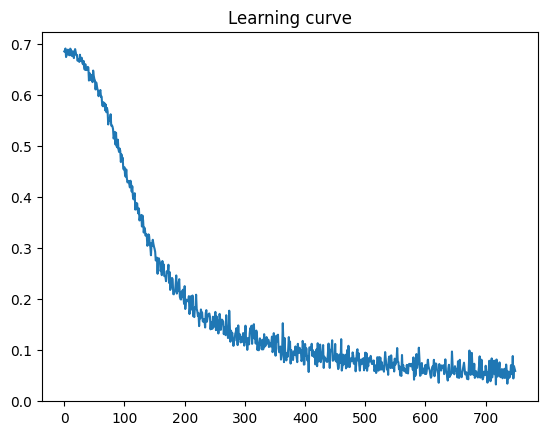

In [32]:
plt.plot(J_list)
plt.title("Learning curve");

In [33]:
y_pred = predict_shallowNN(X_val_b,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_b)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.940


Experiment : 
- `n_nodes = 1,eps = 1e-6,lr = 0.001,max_iterations=1million` --> convergence is reached after 7884 epochs, accuracy of 0.94, may overfit, reduce the max_iteration
- `n_nodes = 1,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> convergence not reached, accuracy of 0.95, increase number of nodes
- `n_nodes = 2,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> convergence not reached accuracy of 0.95. increase number of nodes
- `n_nodes = 5,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> still 0.95, decrease max_iteration
- `n_nodes = 5,eps = 1e-6,lr = 0.001,max_iterations= 150 000` --> still 0.95

It seems like I can not improve 0.95 which is less than logistic regression 0.96. I can select any setting

In [34]:
## train on train + validation
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_b_tot,y_train_b_tot,n_nodes,eps = 1e-6,lr = 0.001,sigma=0.1,max_iterations=500000)

max iteration reached, convergence is not reached you may need to adjust parameters


In [35]:
y_pred = predict_shallowNN(X_test_b,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_b)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.980


I got 0.98 which is less than 0.99 in logistic regression. 


**Conclusion** : for the blob data set complex model is not needed, logistic regression is enough !

#### Circle dataset

In [36]:
n_nodes = 10
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_c,y_train_c,n_nodes,lr = 0.001,eps = 1e-8,max_iterations=3000000)

max iteration reached, convergence is not reached you may need to adjust parameters


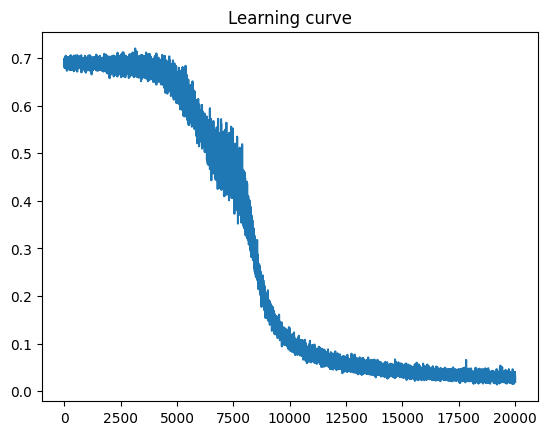

In [37]:
plt.plot(J_list)
plt.title("Learning curve");

- Take a long time before decreasing, therefore i will lower the treshold to avoid stopping to early

In [38]:
y_pred = predict_shallowNN(X_val_c,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_c)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.983


Experiment : 
- `n_nodes = 5,lr = 0.001,eps = 1e-7,max_iterations=1000000` -->  takes a long time to decrease, convergence not reached, accuracy = 0.912, increase the number of iterations  
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations=2000000` --> 0.977, let's increase max_iteration again   
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 3000000` --> 0.989, better, lets increase again 
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 5000000` --> 0.977, slighly overfit, lets increase the number of nodes
- `n_nodes = 10,lr = 0.001,eps = 1e-8,max_iterations= 3000000` --> 0.977


Best model found : `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 3000000`

In [39]:
# train on train + validation
X_train_c_tot = np.concatenate((X_train_c, X_val_c), axis=0)
y_train_c_tot = np.concatenate((y_train_c, y_val_c), axis=0)
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_c_tot,y_train_c_tot,n_nodes=5,lr = 0.001,eps = 1e-8,max_iterations=3000000)

max iteration reached, convergence is not reached you may need to adjust parameters


In [40]:
# test
y_pred = predict_shallowNN(X_test_c,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_c)
print(f'Test Accuracy score : {acc: .3f}')

Test Accuracy score :  0.994


#### Visualisation

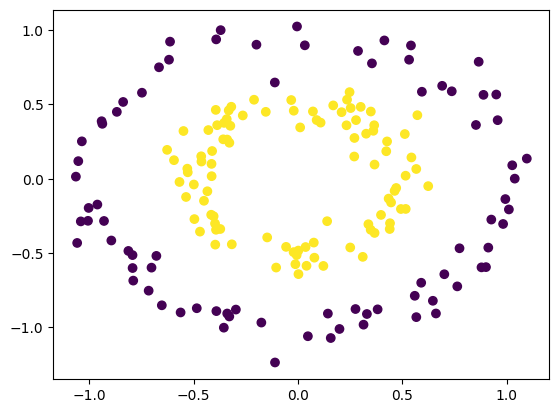

In [41]:
plt.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_pred, cmap='viridis');

## Part 4 : Training the shallow neural net on MNIST

### Load dataset

In [42]:
# This function taken directly from the Fashion-MNIST github site: 
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

# Note: first arg is the path name, second is the file prefix, either 'train' or 't10k' (which is 10k of test data)
def load_mnist(path, kind='train'): 
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [43]:
(train_imgs, train_labels) = load_mnist('./fashion-mnist-data', 'train')
(test_imgs, test_labels) = load_mnist('./fashion-mnist-data', 't10k')

In [44]:
label_names = ['T-shirt/top', 'Trouser' , 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [45]:
print(f"Shape of images is {train_imgs.shape}, labels is {train_labels.shape}")

Shape of images is (60000, 784), labels is (60000,)


#### Select the class

In [46]:
SELETCED_CLASS = ['Shirt', 'Sandal']
class1_index = label_names.index(SELETCED_CLASS[0])
class2_index = label_names.index(SELETCED_CLASS[1])


In [47]:
# Filter train data
train_indices = np.where((train_labels == class1_index) | (train_labels == class2_index))
train_imgs = train_imgs[train_indices]
train_labels = train_labels[train_indices]

# Filter test data
test_indices = np.where((test_labels == class1_index) | (test_labels == class2_index))
test_imgs = test_imgs[test_indices]
test_labels = test_labels[test_indices]

# Replace labels to 0 and 1 
train_labels[train_labels == class1_index] = 0
train_labels[train_labels == class2_index] = 1

test_labels[test_labels == class1_index] = 0
test_labels[test_labels == class2_index] = 1

unique_labels, counts = np.unique(train_labels, return_counts=True)
unique_labelst, countst = np.unique(test_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")

Label 0: 6000 samples
Label 1: 6000 samples


In [48]:
# Uncoment this section to select fewer sample
#num_samples_to_choose = 6000

# Generate random indices to select 500 samples
#random_indices = np.random.choice(train_imgs.shape[0], num_samples_to_choose, replace=False)

# Select the random samples from filtered training data
#train_imgs = train_imgs[random_indices]
#train_labels = train_labels[random_indices]

In [49]:
X_train_mnist_tot = train_imgs/255 # Normalising pixel to range 0 to 1
y_train_mnist_tot = train_labels

#### Train / Validation split

In [50]:
X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(X_train_mnist_tot, y_train_mnist_tot, test_size=0.7, random_state=42)

In [51]:
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_mnist,y_train_mnist,15,lr=0.01,eps = 1e-4,display = True)

epoch 1 J = 0.18910151944316192
epoch 2 J = 0.028905040795680893
epoch 3 J = 0.019354157187087107
epoch 4 J = 0.01324162196724173
epoch 5 J = 0.010254628578185222
epoch 6 J = 0.007202737774261011
epoch 7 J = 0.00983519733967765
epoch 8 J = 0.004755691982020495
epoch 9 J = 0.008086028242756487
epoch 10 J = 0.005242115479373157
epoch 11 J = 0.005535245770404707
epoch 12 J = 0.003320624816159506
epoch 13 J = 0.004439448696024076
epoch 14 J = 0.006132126716572327
epoch 15 J = 0.004547967469590801
epoch 16 J = 0.0035854645715257547
epoch 17 J = 0.004701222723652021
epoch 18 J = 0.003296128278933723
epoch 19 J = 0.0029852686835519634
epoch 20 J = 0.002374439326804846
epoch 21 J = 0.0030501655695068367
epoch 22 J = 0.0024205668427133434
epoch 23 J = 0.002141461773939848
epoch 24 J = 0.0020242523206529892
epoch 25 J = 0.002424860038635681
epoch 26 J = 0.0018996213964743089
epoch 27 J = 0.0018333797094309944
Training complete, convergence is reached after 27 epochs


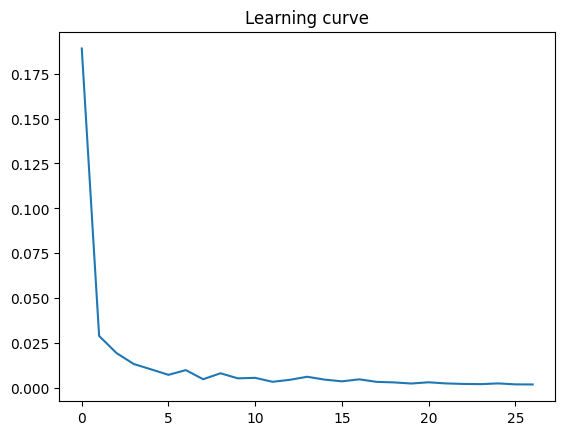

In [52]:
plt.plot(J_list)
plt.title("Learning curve");

Notes : 
- there is much more data than blob or circle so for the same number of iteration there is much less epoch

In [53]:
y_pred = predict_shallowNN(X_val_mnist,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.998


Experiment : 
- `n_nodes = 10,lr=0.01,eps = 1e-3`  --> 0.998, already very good !, lower eps
- `n_nodes = 10,lr=0.01,eps = 1e-4`  --> 0.998, not improving, increase number of nodes
- `n_nodes = 15,lr=0.01,eps = 1e-4` --> still 0.998

I choose the first model because same result for less training time and avoid overfitting

In [54]:
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_mnist_tot,y_train_mnist_tot,10,lr=0.01,eps = 1e-3,display=True)

epoch 1 J = 0.07411449612991819
epoch 2 J = 0.012308285178004657
epoch 3 J = 0.008461021497196072
epoch 4 J = 0.007059714125687026
epoch 5 J = 0.0035559270969070128
epoch 6 J = 0.0046933777531062626
epoch 7 J = 0.004229242106058846
Training complete, convergence is reached after 7 epochs


In [55]:
X_test_mnist = test_imgs/255
y_test_mnist = test_labels
y_pred = predict_shallowNN(X_test_mnist,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_mnist)
print(f'Accuracy score : {acc: .3f}')
cm = confusion_matrix(y_test_mnist, y_pred)
cm

Accuracy score :  0.999


array([[ 998,    2],
       [   0, 1000]])

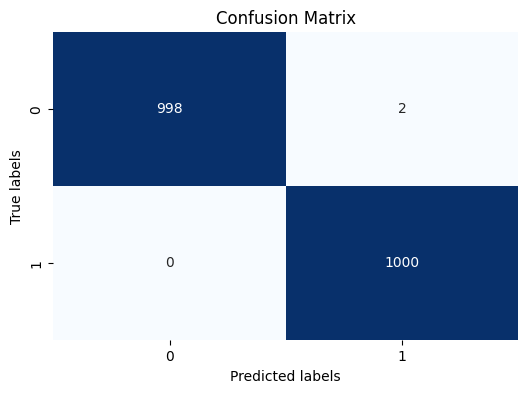

In [56]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Only two misclasified !

## Part 5 : Deep Neural Nett and Enhancement
### Deep neural net

First, let's focus on the implementation for any number of layer and any number of nodes for each layer. The algorithm stays similar to shallow neural net with the difference of computing forward pass and backward for each layer. 

Implementation details :
- I reused the previous code because it is again the same structure.  
- The challenging part for me is to find the right data structure not really for effeciency but rather for understanding and keep it close to the formulas.  
- I choosed to store every weight, z-value and a-value in a python list, where the index correspond to the layer. 
- For each layer l stored the corresponding parameter in a numpy array as before. 

The code bellow is showing how I initilised it with a for loop and then printing the shape for each layer to check wether it's right shape.  
The list `struct` is representing the structure of the network, the first item is the number of node of first layer and so on. 

In [57]:
## test for parameter initialisation
struct = [10,20,30,20,10] # An example of a deep structure
stopping = False
# initialize parameters
X = X_train_b

# First layer
W = [np.random.normal(size=(struct[0], X.shape[1]))]
b = [np.random.normal(size = (struct[0]))]
for i in range(len(struct)-1):
    W.append(np.random.normal(size=(struct[i+1],struct[i]))) # first index is next node, second index is current node
    b.append(np.random.normal(size=(struct[i+1])))

# Last layer
W.append(np.random.normal(size=(1,struct[-1])))
b.append(np.random.normal(size=(1)))
for i in range(len(W)):
    print(f"W{i} shape is {W[i].shape}")
    print(f"b{i} shape is {b[i].shape}")

print(f"number of layers :  {len(W)}")

W0 shape is (10, 3)
b0 shape is (10,)
W1 shape is (20, 10)
b1 shape is (20,)
W2 shape is (30, 20)
b2 shape is (30,)
W3 shape is (20, 30)
b3 shape is (20,)
W4 shape is (10, 20)
b4 shape is (10,)
W5 shape is (1, 10)
b5 shape is (1,)
number of layers :  6


Other implementation details : 
- We need to pay attention to the notation. Indeed a python list start at index 0 but the formulas start with layer 1 !
- This can lead to confusion espcecially because the formulas says $a^{[0]}$ correspond to `x`
- Therefore, I did the last backprop for the input layer outside the loop "manually" replacing $a^{[0]}$ by `x`
- Also, I did not use vectorisation AT ALL even for forward prop because it was more simple to understand and avoid any matrix multiplication error
- The algorithm is slower than the other because forward prop is done without vectorisation

In [58]:
def NeuralNet(X,Y,struct,lr = 0.001, max_iterations = 10000000,eps = 1e-4,nu = 0,sigma = 0.1,display=False):
    stopping = False
    # initialize parameters
    W = [np.random.normal(nu,sigma,size=(struct[0], X.shape[1]))]
    b = [np.random.normal(nu,sigma,size = (struct[0]))]
    for i in range(len(struct)-1):
        W.append(np.random.normal(nu,sigma,size=(struct[i+1],struct[i])))
        b.append(np.random.normal(nu,sigma,size=(struct[i+1])))
    W.append(np.random.normal(nu,sigma,size=(1,struct[-1])))
    b.append(np.random.normal(nu,sigma,size=(1)))

    N = len(X[:,1])
    N_layer = len(W)
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0

    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        z = [0] * N_layer
        a = [0] * N_layer
        
        # forward propagation 

        # First layer

        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            
            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])



        y_hat = a[-1][0]
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat + 1e-8))
    

        # Backward Propagation 
        DZ = [0] * N_layer
        DW = [0] * N_layer
        DB = [0] * N_layer

        # Output layer
        DZ[-1] = np.array([y_hat - y])
        DW[-1] = DZ[-1] * a[N_layer-2]
        DB[-1] = DZ[-1]


        # hidden layer
        for l in range(N_layer-2,0,-1): # loop backward
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_next = W[l+1].shape[0] # number of node of layer l + 1
            n_nodes_before = W[l-1].shape[0] # number of node of layer l - 1
            
            # DZ 
            DZ[l] = np.zeros(shape=(n_nodes))
            for i in range(n_nodes):
                DZ[l][i] = dsigmoid(z[l][i]) * sum([DZ[l+1][j] * W[l+1][j,i] for j in range(n_nodes_next)])
    
            # DW and DB
            DW[l] = np.zeros(shape=(n_nodes,n_nodes_before))
            DB[l] = np.zeros(shape=(n_nodes))
            for j in range(n_nodes):
                DB[l][j] = DZ[l][j]
                for i in range(n_nodes_before):
                    DW[l][j,i] = DZ[l][j] * a[l-1][i]

        # First layer
          
        n_nodes = W[0].shape[0] # number of node of current layer 0
        n_nodes_next = W[1].shape[0] # number of node of layer 1
        n_nodes_before = W[0].shape[1] # Input layer size

        DZ[0] = np.zeros(shape=(n_nodes))
        for i in range(n_nodes):
            DZ[0][i] = dsigmoid(z[0][i]) * sum([DZ[1][j] * W[1][j,i] for j in range(n_nodes_next)])
        DW[0] = np.zeros(shape=(n_nodes,n_nodes_before))
        DB[0] = np.zeros(shape=(n_nodes))

        for j in range(n_nodes):
            DB[0][j] = DZ[0][j]
            for i in range(n_nodes_before):
                DW[0][j,i] = DZ[0][j] * x[i]
            

        #Gradient descent 
        for l in range(len(W)):
            W[l] -= lr*DW[l]
            b[l] -= lr*DB[l]

        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            if display == True :
                print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W,b)              
                           
                

In [59]:
def predict_NN(X,W,b):
    N_layer = len(W)
    z = [0] * N_layer
    a = [0] * N_layer
    y_pred = []
    for i in range(len(X[:,1])):
        x = X[i]
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            
            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])

        y_hat = a[-1][0]
        y_pred.append(y_hat)

    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary
        
    

#### Test on MNIST

In [60]:
struct = [10,5]
J_list,W,b = NeuralNet(X_train_mnist,y_train_mnist,struct,lr=0.01,eps =1e-3,display = True)

epoch 1 J = 0.693483027304111
epoch 2 J = 0.6265779292780896
epoch 3 J = 0.14452158338141585
epoch 4 J = 0.03834761002026446
epoch 5 J = 0.024587875615581078
epoch 6 J = 0.017808244981112675
epoch 7 J = 0.015683353324271496
epoch 8 J = 0.010929575801744439
epoch 9 J = 0.011752128462086772
Training complete, convergence is reached after 9 epochs


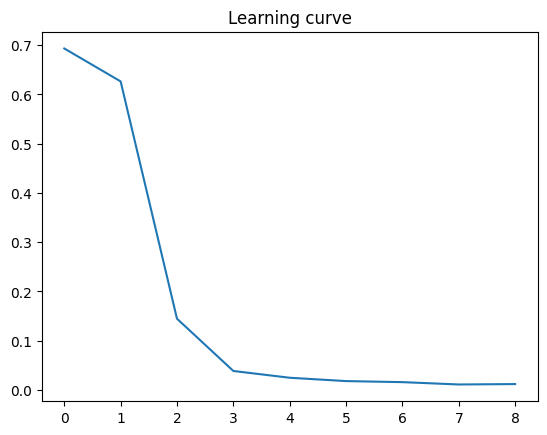

In [61]:
plt.plot(J_list)
plt.title("Learning curve");

In [62]:
y_pred = predict_NN(X_val_mnist,W,b)
acc = accuracy_score(y_pred,y_val_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.998


Experiment : 
- `struct = [10,3], lr=0.01,eps =1e-3` --> 0.997 
- `struct = [10,5], lr=0.01,eps =1e-3` --> 0.998

I will choose the last structure

In [63]:
J_list,W,b = NeuralNet(X_train_mnist_tot,y_train_mnist_tot,[10,5],lr=0.01,eps =1e-3,display=True)

epoch 1 J = 0.38817469765716783
epoch 2 J = 0.021485864638170614
epoch 3 J = 0.012290283531517723
epoch 4 J = 0.007371915090014592
epoch 5 J = 0.005762705914079167
epoch 6 J = 0.004914389288363768
Training complete, convergence is reached after 6 epochs


In [64]:
y_pred = predict_NN(X_test_mnist,W,b)
acc = accuracy_score(y_pred,y_test_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.999


Accuracy of 1 on test set !

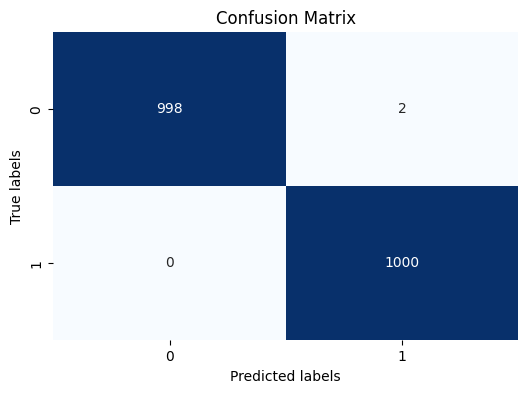

In [65]:
cm = confusion_matrix(y_test_mnist, y_pred)
cm
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Enhancement

I had to choose one enhancement in the following list : 
- Multi class problem
- Mini Batch GD
- L1 or L2 Regularisation
- Early stopping
- gradient descent with momentum or RMSprop
- Adam Optimizer

The enhancement I choosed is multi class to solve mnist for all classes. 
Difference in the code : 
- The input label y need to be encoded in a vector enc_y where `enc_y[i] = 1` if `y = 1` and `0` for the rest
- The parameter in the output does not have the same size it's `(N_class,n_nodes)` instead of `(1,n_nodes)`
- Last layer activation function is softmax and not sigmoid
- The back prop in the last layer change a little bit because of the soft max function. 
- The derivative of J with respcect to $z^{[L]}$ is now a vector $(\hat{y} - y)$
- The rest stay the same


In [66]:
def softmax(z):
    s = sum([np.exp(z[i]) for i in range(len(z))])
    return np.exp(z)/s

In [67]:
#test of softmax
softmax(np.array([0,1.4,0.5,0.6]))

array([0.11728774, 0.47562525, 0.1933748 , 0.2137122 ])

In [68]:
def NeuralNet_bis(X,Y,struct,lr = 0.001, max_iterations = 1000000,eps = 1e-4,nu = 0,sigma=0.1,display = False):
    
    N = len(X[:,1])
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    class_name = np.unique(Y)
    N_class = len(class_name) # number of class
    stopping = False

    # initialize parameters
    W = [np.random.normal(nu,sigma,size=(struct[0], X.shape[1]))]
    b = [np.random.normal(nu,sigma,size = (struct[0]))]
    for i in range(len(struct)-1):
        W.append(np.random.normal(nu,sigma,size=(struct[i+1],struct[i])))
        b.append(np.random.normal(nu,sigma,size=(struct[i+1])))

    W.append(np.random.normal(nu,sigma,size=(N_class,struct[-1]))) # change here because last layer has N_class nodes
    b.append(np.random.normal(nu,sigma,size=(N_class)))
    N_layer = len(W)


    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]


        # Encoding the class number to a one hot vector
        enc_y = [0] * N_class
        enc_y[y] = 1
        enc_y = np.array(enc_y)


        z = [0] * N_layer
        a = [0] * N_layer
        
        # forward propagation 

        # First layer
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer-1):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            

            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])


        z[-1] = np.zeros(shape=(N_class))
        for i in range(N_class):
            z[-1][i] = sum([W[-1][i,j] * a[-2][j] for j in range(struct[-1])]) + b[-1][i]
        a[-1] = softmax(z[-1])
        y_hat = a[-1]
        J_current = - sum([enc_y[i] * np.log(y_hat[i]) for i in range(N_class)])
    

        # Backward Propagation 
        DZ = [0] * N_layer
        DW = [0] * N_layer
        DB = [0] * N_layer

        # Output layer
        DZ[-1] = np.zeros(shape=(N_class))
        for j in range(N_class):
            DZ[-1][j] = a[-1][j] - enc_y[j]

        
        DW[-1] = np.zeros(shape=(N_class,struct[-1]))
        DB[-1] = np.zeros(shape=(N_class))
        for j in range(N_class):
            DB[-1][j] = DZ[-1][j]
            for i in range(struct[-1]):
                DW[-1][j,i] = DZ[-1][j] * a[N_layer-2][i]
        
        # hidden layer
        for l in range(N_layer-2,0,-1): 
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_next = W[l+1].shape[0] # number of node of layer l + 1
            n_nodes_before = W[l-1].shape[0] # number of node of layer l - 1
            
            # DZ 
            DZ[l] = np.zeros(shape=(n_nodes))
            for i in range(n_nodes):
                DZ[l][i] = dsigmoid(z[l][i]) * sum([DZ[l+1][j] * W[l+1][j,i] for j in range(n_nodes_next)])

            # DW and DB
            DW[l] = np.zeros(shape=(n_nodes,n_nodes_before))
            DB[l] = np.zeros(shape=(n_nodes))
            for j in range(n_nodes):
                DB[l][j] = DZ[l][j]
                for i in range(n_nodes_before):
                    DW[l][j,i] = DZ[l][j] * a[l-1][i]

        # First layer
          
        n_nodes = W[0].shape[0] # number of node of current layer 0
        n_nodes_next = W[1].shape[0] # number of node of layer 1
        n_nodes_before = W[0].shape[1] # Input layer size

        DZ[0] = np.zeros(shape=(n_nodes))
        for i in range(n_nodes):
            DZ[0][i] = dsigmoid(z[0][i]) * sum([DZ[1][j] * W[1][j,i] for j in range(n_nodes_next)])
        DW[0] = np.zeros(shape=(n_nodes,n_nodes_before))
        DB[0] = np.zeros(shape=(n_nodes))
        
        for j in range(n_nodes):
            DB[0][j] = DZ[0][j]
            for i in range(n_nodes_before):
                DW[0][j,i] = DZ[0][j] * x[i]
            
        #Gradient descent 
        for l in range(len(W)):
            W[l] -= lr*DW[l]
            b[l] -= lr*DB[l]

        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            if display == True:
                print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W,b)              
                           
                

In [69]:
def predict_NN_bis(X,W,b):
    N_layer = len(W)
    z = [0] * N_layer
    a = [0] * N_layer
    y_pred = []
    N_class = W[-1].shape[0]
    for i in range(len(X[:,1])):
        x = X[i]
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer-1):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            

            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])
        z[-1] = np.zeros(shape=(N_class))
        for i in range(N_class):
            z[-1][i] = sum([W[-1][i,j] * a[-2][j] for j in range(struct[-1])]) + b[-1][i]
        a[-1] = softmax(z[-1])
        y_hat = a[-1]

        y_hat = a[-1]
        y_pred.append(y_hat)

    y_pred_final = [np.argmax(y) for y in y_pred]
    return y_pred_final

## Part 6 : Test of the multiclass algorithm on MNIST
### Testing only 2 classes

In [70]:
struct = [10,3]
J_list,W,b = NeuralNet_bis(X_train_mnist,y_train_mnist,struct,lr=0.01,eps =1e-3,display=True)

epoch 1 J = 0.6599063846754968
epoch 2 J = 0.1765532696054594
epoch 3 J = 0.03990097955989464
epoch 4 J = 0.022516499379280155
epoch 5 J = 0.017366659022937558
epoch 6 J = 0.013625805313764712
epoch 7 J = 0.012030864165555382
epoch 8 J = 0.013290353692766774
epoch 9 J = 0.00959765695453756
epoch 10 J = 0.008583539365928965
epoch 11 J = 0.006150674547535253
epoch 12 J = 0.0066355901736816795
Training complete, convergence is reached after 12 epochs


Still working !

### Testing with all 9 classes

In [71]:
# Reload the whole dataset
(train_imgs, train_labels) = load_mnist('./fashion-mnist-data', 'train')
(test_imgs, test_labels) = load_mnist('./fashion-mnist-data', 't10k')

In [72]:
num_samples_to_choose = 10000 


random_indices = np.random.choice(train_imgs.shape[0], num_samples_to_choose, replace=False)

# Select the random samples from filtered training data
train_imgs = train_imgs[random_indices]
train_labels = train_labels[random_indices]

Notes : I did not stratified the so the number of sample for each class is random. One improvement could be making sure that each class has the same number of sample

In [73]:
X_train_mnist_multi_tot = train_imgs/255
y_train_mnist_multi_tot = train_labels

X_train_mnist_multi, X_val_mnist_multi, y_train_mnist_multi, y_val_mnist_multi = train_test_split(X_train_mnist_multi_tot, y_train_mnist_multi_tot, test_size=0.7, random_state=42)

In [74]:
struct = [10,5]
J_list,W,b = NeuralNet_bis(X_train_mnist_multi,y_train_mnist_multi,struct,lr=0.01,eps =1e-3,sigma = 0.1)

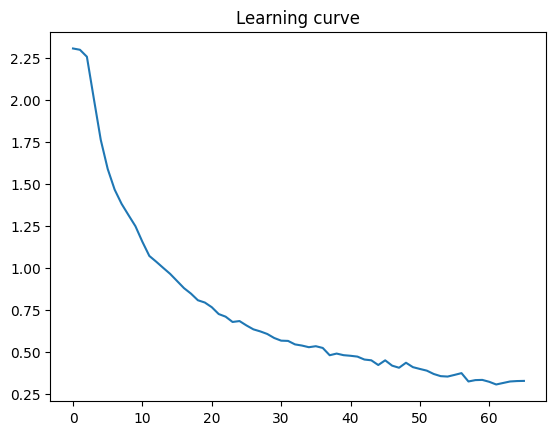

In [ ]:
plt.plot(J_list)
plt.title("Learning curve");

In [ ]:
y_pred = predict_NN_bis(X_val_mnist_multi,W,b)
acc = accuracy_score(y_pred,y_val_mnist_multi)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.797


Experiment : 
- `struct = [10,5],lr=0.01,eps =1e-3` --> 0.75 Training was 10 minutes long so I will not do a lot of experiment. Add a third layer
- 'struct = [10,5,10],lr=0.01,eps =1e-3' --> 0.02 very bad result the algorithm converges after 2 epochs with no improvement
- 'struct = [10,5,3],lr=0.01,eps =1e-3,sigma = 1' --> 0.56 I changed sigma and I obtained better results but still not as good as the first one

I will keep the first setting for testing

In [ ]:
J_list,W,b = NeuralNet_bis(X_train_mnist_multi_tot,y_train_mnist_multi_tot,[10,5],lr=0.01,eps =1e-3)

epoch 1 J = 2.1909936349371195
epoch 2 J = 1.602347535603032
epoch 3 J = 1.2943909443917863
epoch 4 J = 1.1283967347965795
epoch 5 J = 1.0196102362787098
epoch 6 J = 0.9169154849079909
epoch 7 J = 0.840712570872699
epoch 8 J = 0.7717405360859502
epoch 9 J = 0.7038494953467886
epoch 10 J = 0.6635637558955002
epoch 11 J = 0.6328517259473257
epoch 12 J = 0.586425551280212
epoch 13 J = 0.5850560337144327
epoch 14 J = 0.5577840941108164
epoch 15 J = 0.5235431155374886
epoch 16 J = 0.5029219940931272
epoch 17 J = 0.47823330050586227
epoch 18 J = 0.4721610992509217
epoch 19 J = 0.4617511642192707
epoch 20 J = 0.4630723383334549
epoch 21 J = 0.45502596663121603
epoch 22 J = 0.4323571840375469
epoch 23 J = 0.419788465440353
epoch 24 J = 0.419280069902965
Training complete, convergence is reached after 24 epochs


In [ ]:
X_test_mnist_multi = test_imgs/255
y_test_mnist_multi = test_labels

y_pred = predict_NN_bis(X_test_mnist_multi,W,b)
acc = accuracy_score(y_pred,y_test_mnist_multi)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.806


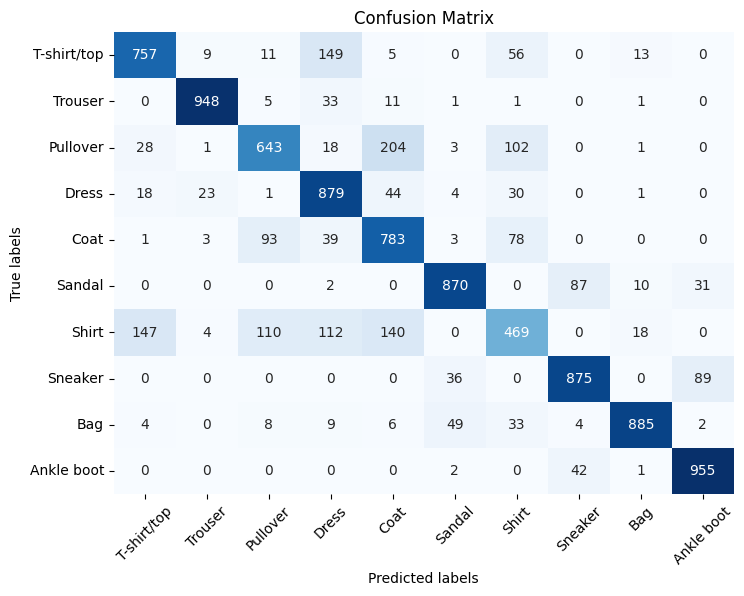

In [ ]:
cm = confusion_matrix(y_test_mnist_multi, y_pred)
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks + 0.5, label_names, rotation=45)
plt.yticks(tick_marks + 0.5, label_names, rotation=0)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

plt.show()


**comment :**
- good results overall
- class shirt is often confused with T shirt/top, Pullover, dess and coats
- class pullover is often confused with coats and shirt
- Class T-shirt/Top is often confused with dress

#### Further improvement possible : 
- Add validation held-out data and evaluate during training (better detection of overfitting)
- Have a better display during training maybe with a progress bar with the current value of J. Or even visualise the learning curve grow during the training.
- Use cross validation and gridsearch instead of manual experiment to tune parameters
- Decompose the code into sub function e.g. forward(), backward() or initialise_parameter(),check_for_convergence(). This could improve the readability of the code and if I want to change one part I do not have to modify all codes I just need to change the function.
- Design an object - oriented style project. Creating a class for each model and then call instances of the class to train and test. It can be interesting but I think it won't help understanding the algorithm
- Add other enhancement mentioned before. Espcially the mini batch for full use for an more effecient algorithm
- Use CNN for image usually provides better results
- Try image augmentatiom for fashion mnist (we can it is not digit !) and see if it can generalise better.